In [ ]:
!pip install mljar-supervised

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

def clean_input_csv (url):
    df = pd.read_csv(url,na_values='.') # The na_values setting replaces NaN/null values with a floating-point and string compatible dot
    #df = df.sample(frac=1, random_state=1).reset_index() #okay actuall test train split already shuffles so this line is redundant

    # Change non-numerical columns to 'category' a statistical-category datatype understood by scikit,etc
    cols = df.select_dtypes(include='object').columns
    #df[cols] = df[cols].fillna('MissingValues')
    df[cols] = df[cols].astype('category')

    # Remove columns that are due to contact with voters because that's a bias to prediction
    disallow=['mAddress','Address','PreferredEmail','VoterVolunteer','Volunteer_Ask','Notes','Heard_about_Rana?']
    df = df.drop(disallow, axis=1)

    # Drop columns where y is null from test/train set
    df_after_dropping = df.dropna(axis='index',subset=['Support_Rana?'])
    needs_predictions = df[~df.index.isin(df_after_dropping.index)]
    df = df_after_dropping

    #Cleanup NaN/null in numeric columns
    # select numeric columns
    numeric_columns = df.select_dtypes(exclude=['category']).columns

    # fill 0 to all NaN 
    df[numeric_columns] = df[numeric_columns].fillna('0').apply(pd.to_numeric)

    # Split out the target column
    y = df['Support_Rana?'].str.replace('[^0-9]','').apply(pd.to_numeric).replace(2,1).replace(3,0).replace(4,0).replace(5,0).astype('int64')
    X = df.drop('Support_Rana?',axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)
    return X, y

#csvs
url_all_ids_may10 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTMcVu8cf1ZEFK6yuHn3xgJrT5L5jTQa7GY9zuRaIvgyrYBpWL08iyAcvbWT9kyulrs1PT3u1HyrRGz/pub?gid=1976628524&single=true&output=csv'
url_all_phones_may3 = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTd1WpzujmHh-qYe19ddQPSWFnrdmHM6g0XvblVcAVAVhwgM91qQKM4Hyvvi58fSnoGpjcWcXG3FSr6/pub?gid=616038225&single=true&output=csv'

# Import all phones may 3
X, y = clean_input_csv(url_all_phones_may3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The default value of regex will change from True to False in a future version.


In [4]:
from supervised.automl import AutoML
import numpy as np

automl = AutoML()
automl.fit(X_train, y_train)

predictions = automl.predict(X_test)

AutoML directory: AutoML_1
The task is binary_classification with evaluation metric logloss
AutoML will use algorithms: ['Baseline', 'Linear', 'Decision Tree', 'Random Forest', 'Xgboost', 'Neural Network']
AutoML will ensemble available models
AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline logloss 0.685314 trained in 0.46 seconds
2_DecisionTree logloss 2.45094 trained in 10.79 seconds
3_Linear logloss 0.788333 trained in 4.85 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost logloss 0.687892 trained in 6.45 seconds
5_Default_NeuralNetwork logloss 0.684612 trained in 2.3 seconds
6_Default_RandomForest logloss 0.66539 trained in 10.07 seconds
* Step ensemble will try to check up to 1 model
Ensemble logloss 0.66539 trained in 0.71 seconds
AutoML fit time: 47.1 seconds
AutoML best model: 6_Default_RandomForest


              precision    recall  f1-score   support

           0       0.67      0.84      0.75       203
           1       0.60      0.36      0.45       133

    accuracy                           0.65       336
   macro avg       0.63      0.60      0.60       336
weighted avg       0.64      0.65      0.63       336



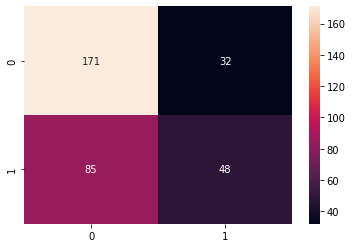

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)
f = sns.heatmap(cm, annot=True, fmt='d')
print(classification_report(y_test, predictions))

In [24]:
predictions_proba = automl.predict_proba(X_test)

In [29]:
pd.DataFrame(predictions_proba).join(pd.DataFrame(y_test).reset_index())

,0,1,index,Support_Rana?
0,0.621462,0.378538,1322,0
1,0.339752,0.660248,74,1
2,0.412049,0.587951,485,1
3,0.656809,0.343191,1375,0
4,0.605264,0.394736,1540,0
...,...,...,...,...
331,0.616583,0.383417,195,0
332,0.426638,0.573362,1309,1
333,0.591949,0.408051,1318,1
334,0.520330,0.479670,112,1
